In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import math

In [2]:
dataframe = pd.read_csv('preprocessedData.csv', index_col = 'ReadingDateTime', parse_dates = True)
dataframe

,BP,NO,NO2,NOX,SO2,SOLR,WDIR,WSPD
ReadingDateTime,,,,,,,,
2014-01-01 00:00:00,997.0,0.1,15.1,15.2,2.4,0.0,187.0,4.9
2014-01-01 00:15:00,997.0,0.1,15.1,15.2,2.4,0.0,187.0,4.9
2014-01-01 00:30:00,997.0,0.1,15.1,15.2,2.4,0.0,192.0,3.5
2014-01-01 00:45:00,997.0,0.1,15.1,15.2,2.4,0.0,209.0,3.5
2014-01-01 01:00:00,997.0,0.1,15.1,15.2,2.4,0.0,203.0,3.2
...,...,...,...,...,...,...,...,...
2018-12-31 22:45:00,1029.0,0.0,3.9,3.9,2.3,5.0,282.0,0.2
2018-12-31 23:00:00,1029.0,0.0,3.9,3.9,2.3,5.0,282.0,0.2
2018-12-31 23:15:00,1029.0,0.0,3.9,3.9,2.3,5.0,272.0,0.2


In [3]:
def shiftFiveReadings(dataframe, name):
    data = dataframe.copy()
    newColumn1 = name + "_Previous_1st_Reading"
    data[newColumn1] = dataframe[name].shift(+1)
      
    newColumn2 = name + "_Previous_2nd_Reading"
    data[newColumn2] = dataframe[name].shift(+2)
        
    newColumn3 = name + "_Previous_3rd_Reading"
    data[newColumn3] = dataframe[name].shift(+3)
        
    newColumn4 = name + "_Previous_4th_Reading"
    data[newColumn4] = dataframe[name].shift(+4)
       
    newColumn5 = name + "_Previous_5th_Reading"
    data[newColumn5] = dataframe[name].shift(+5)
    return data

In [4]:
dataframeA = shiftFiveReadings(dataframe, 'NOX')
dataframeA.interpolate(method = 'linear', axis = 0, limit_direction = 'both', inplace = True)
features = dataframeA[dataframeA.columns.difference(['NOX'])]
output = dataframeA['NOX']
training_features, testing_features, training_output, testing_output = train_test_split(features, output, test_size = 0.30)

In [5]:
NOX_correlation_values = dataframeA.corr()['NOX'].drop('NOX')
weights = [NOX_correlation_values['BP']]
weights.append(NOX_correlation_values['NO'])
weights.append(NOX_correlation_values['NO2'])
weights.append(NOX_correlation_values['NOX_Previous_1st_Reading'])
weights.append(NOX_correlation_values['NOX_Previous_2nd_Reading'])
weights.append(NOX_correlation_values['NOX_Previous_3rd_Reading'])
weights.append(NOX_correlation_values['NOX_Previous_4th_Reading'])
weights.append(NOX_correlation_values['NOX_Previous_5th_Reading'])
weights.append(NOX_correlation_values['SO2'])
weights.append(NOX_correlation_values['SOLR'])
weights.append(NOX_correlation_values['WDIR'])
weights.append(NOX_correlation_values['WSPD'])

print(weights)

[0.06055884157236485, 0.7665884626845045, 0.9296558955030992, 0.9795485261346016, 0.9533858039590984, 0.9272873288032956, 0.9005525195897944, 0.8735216004441083, 0.06888469870174777, -0.1668315570725028, -0.015460039668030386, -0.34408700547578164]


In [6]:
def pearsonWeightedDistance(vectorA, vectorB):
    return np.sqrt(np.sum(np.square(abs(np.multiply(weights, (vectorA - vectorB))))))

In [7]:
knnRegressor = neighbors.KNeighborsRegressor(n_jobs = -1, n_neighbors = 11, metric = pearsonWeightedDistance)
knnRegressor.fit(training_features, training_output)

KNeighborsRegressor(metric=<function pearsonWeightedDistance at 0x000001D6E6636820>,
                    n_jobs=-1, n_neighbors=11)

In [8]:
start = time.time()

prediction = pd.Series(knnRegressor.predict(testing_features[0 : 500]), index = testing_features.index[0 : 500]).astype('float64')
print("1st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[500 : 1000]), index = testing_features.index[500 : 1000])])
print("2nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[1000 : 1500]), index = testing_features.index[1000 : 1500])])
print("3rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[1500 : 2000]), index = testing_features.index[1500 : 2000])])
print("4th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[2000 : 2500]), index = testing_features.index[2000 : 2500])])
print("5th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[2500 : 3000]), index = testing_features.index[2500 : 3000])])
print("6th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[3000 : 3500]), index = testing_features.index[3000 : 3500])])
print("7th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[3500 : 4000]), index = testing_features.index[3500 : 4000])])
print("8th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[4000 : 4500]), index = testing_features.index[4000 : 4500])])
print("9th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[4500 : 5000]), index = testing_features.index[4500 : 5000])])
print("10th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[5000 : 5500]), index = testing_features.index[5000 : 5500])])
print("11th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[5500 : 6000]), index = testing_features.index[5500 : 6000])])
print("12th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[6000 : 6500]), index = testing_features.index[6000 : 6500])])
print("13th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[6500 : 7000]), index = testing_features.index[6500 : 7000])])
print("14th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[7000 : 7500]), index = testing_features.index[7000 : 7500])])
print("15th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[7500 : 8000]), index = testing_features.index[7500 : 8000])])
print("16th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[8000 : 8500]), index = testing_features.index[8000 : 8500])])
print("17th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[8500 : 9000]), index = testing_features.index[8500 : 9000])])
print("18th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[9000 : 9500]), index = testing_features.index[9000 : 9500])])
print("19th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[9500 : 10000]), index = testing_features.index[9500 : 10000])])
print("20th iteration - ", time.time())

print(prediction)

1st iteration -  1651053389.1461189
2nd iteration -  1651054443.4028842
3rd iteration -  1651055471.7046182
4th iteration -  1651056493.6188488
5th iteration -  1651057754.0458546
6th iteration -  1651058701.1614075
7th iteration -  1651059143.139276
8th iteration -  1651059674.6898386
9th iteration -  1651060185.6485965
10th iteration -  1651060699.4173286
11th iteration -  1651061229.296757
12th iteration -  1651061648.3326201
13th iteration -  1651061984.5401893
14th iteration -  1651062344.5987937
15th iteration -  1651062674.606144
16th iteration -  1651062993.1213882
17th iteration -  1651063313.965243
18th iteration -  1651063647.783821
19th iteration -  1651063980.439609
20th iteration -  1651064287.8974056
ReadingDateTime
2014-11-27 18:30:00    63.087174
2016-02-20 08:30:00    21.981818
2018-03-28 12:15:00    23.340085
2016-08-25 10:45:00    12.472727
2016-01-26 15:15:00    13.645455
                         ...    
2015-07-29 20:45:00    16.545455
2018-08-18 19:15:00    26.80

In [9]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[10000 : 10500]), index = testing_features.index[10000 : 10500])])
print("21st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[10500 : 11000]), index = testing_features.index[10500 : 11000])])
print("22nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[11000 : 11500]), index = testing_features.index[11000 : 11500])])
print("23rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[11500 : 12000]), index = testing_features.index[11500 : 12000])])
print("24th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[12000 : 12500]), index = testing_features.index[12000 : 12500])])
print("25th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[12500 : 13000]), index = testing_features.index[12500 : 13000])])
print("26th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[13000 : 13500]), index = testing_features.index[13000 : 13500])])
print("27th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[13500 : 14000]), index = testing_features.index[13500 : 14000])])
print("28th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[14000 : 14500]), index = testing_features.index[14000 : 14500])])
print("29th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[14500 : 15000]), index = testing_features.index[14500 : 15000])])
print("30th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[15000 : 15500]), index = testing_features.index[15000 : 15500])])
print("31st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[15500 : 16000]), index = testing_features.index[15500 : 16000])])
print("32nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[16000 : 16500]), index = testing_features.index[16000 : 16500])])
print("33rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[16500 : 17000]), index = testing_features.index[16500 : 17000])])
print("34th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[17000 : 17500]), index = testing_features.index[17000 : 17500])])
print("35th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[17500 : 18000]), index = testing_features.index[17500 : 18000])])
print("36th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[18000 : 18500]), index = testing_features.index[18000 : 18500])])
print("37th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[18500 : 19000]), index = testing_features.index[18500 : 19000])])
print("38th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[19000 : 19500]), index = testing_features.index[19000 : 19500])])
print("39th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[19500 : 20000]), index = testing_features.index[19500 : 20000])])
print("40th iteration - ", time.time())

print(prediction)

21st iteration -  1651064627.3840566
22nd iteration -  1651064971.4968863
23rd iteration -  1651065291.1499846
24th iteration -  1651065624.8282602
25th iteration -  1651065950.9181333
26th iteration -  1651066286.6267712
27th iteration -  1651066623.3064368
28th iteration -  1651066961.4009082
29th iteration -  1651067291.4997256
30th iteration -  1651067626.000585
31st iteration -  1651067962.8857276
32nd iteration -  1651068296.4233658
33rd iteration -  1651068623.8350544
34th iteration -  1651068949.3279164
35th iteration -  1651069281.4229004
36th iteration -  1651069609.199512
37th iteration -  1651070283.4630284
38th iteration -  1651071456.9265788
39th iteration -  1651072598.0664866
40th iteration -  1651073536.5923448
ReadingDateTime
2014-11-27 18:30:00    63.087174
2016-02-20 08:30:00    21.981818
2018-03-28 12:15:00    23.340085
2016-08-25 10:45:00    12.472727
2016-01-26 15:15:00    13.645455
                         ...    
2017-01-17 06:15:00    66.337977
2015-02-15 12:1

In [10]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[20000 : 20500]), index = testing_features.index[20000 : 20500])])
print("41st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[20500 : 21000]), index = testing_features.index[20500 : 21000])])
print("42nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[21000 : 21500]), index = testing_features.index[21000 : 21500])])
print("43rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[21500 : 22000]), index = testing_features.index[21500 : 22000])])
print("44th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[22000 : 22500]), index = testing_features.index[22000 : 22500])])
print("45th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[22500 : 23000]), index = testing_features.index[22500 : 23000])])
print("46th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[23000 : 23500]), index = testing_features.index[23000 : 23500])])
print("47th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[23500 : 24000]), index = testing_features.index[23500 : 24000])])
print("48th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[24000 : 24500]), index = testing_features.index[24000 : 24500])])
print("49th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[24500 : 25000]), index = testing_features.index[24500 : 25000])])
print("50th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[25000 : 25500]), index = testing_features.index[25000 : 25500])])
print("51st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[25500 : 26000]), index = testing_features.index[25500 : 26000])])
print("52nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[26000 : 26500]), index = testing_features.index[26000 : 26500])])
print("53rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[26500 : 27000]), index = testing_features.index[26500 : 27000])])
print("54th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[27000 : 27500]), index = testing_features.index[27000 : 27500])])
print("55th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[27500 : 28000]), index = testing_features.index[27500 : 28000])])
print("56th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[28000 : 28500]), index = testing_features.index[28000 : 28500])])
print("57th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[28500 : 29000]), index = testing_features.index[28500 : 29000])])
print("58th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[29000 : 29500]), index = testing_features.index[29000 : 29500])])
print("59th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[29500 : 30000]), index = testing_features.index[29500 : 30000])])
print("60th iteration - ", time.time())

print(prediction)

41st iteration -  1651074025.967503
42nd iteration -  1651074477.6253054
43rd iteration -  1651074795.7004213
44th iteration -  1651075132.810301
45th iteration -  1651075535.8249848
46th iteration -  1651075883.0845788
47th iteration -  1651076243.4735994
48th iteration -  1651076877.7278798
49th iteration -  1651077908.1935425
50th iteration -  1651078912.2704957
51st iteration -  1651079930.1797428
52nd iteration -  1651080960.5247936
53rd iteration -  1651081963.4663193
54th iteration -  1651082451.032306
55th iteration -  1651082966.445291
56th iteration -  1651083488.884932
57th iteration -  1651084012.6311197
58th iteration -  1651084521.682429
59th iteration -  1651084842.0633175
60th iteration -  1651085181.1760511
ReadingDateTime
2014-11-27 18:30:00    63.087174
2016-02-20 08:30:00    21.981818
2018-03-28 12:15:00    23.340085
2016-08-25 10:45:00    12.472727
2016-01-26 15:15:00    13.645455
                         ...    
2017-03-31 11:15:00    17.627273
2018-01-16 00:45:00

In [11]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[30000 : 30500]), index = testing_features.index[30000 : 30500])])
print("61st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[30500 : 31000]), index = testing_features.index[30500 : 31000])])
print("62nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[31000 : 31500]), index = testing_features.index[31000 : 31500])])
print("63rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[31500 : 32000]), index = testing_features.index[31500 : 32000])])
print("64th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[32000 : 32500]), index = testing_features.index[32000 : 32500])])
print("65th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[32500 : 33000]), index = testing_features.index[32500 : 33000])])
print("66th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[33000 : 33500]), index = testing_features.index[33000 : 33500])])
print("67th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[33500 : 34000]), index = testing_features.index[33500 : 34000])])
print("68th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[34000 : 34500]), index = testing_features.index[34000 : 34500])])
print("69th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[34500 : 35000]), index = testing_features.index[34500 : 35000])])
print("70th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[35000 : 35500]), index = testing_features.index[35000 : 35500])])
print("71st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[35500 : 36000]), index = testing_features.index[35500 : 36000])])
print("72nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[36000 : 36500]), index = testing_features.index[36000 : 36500])])
print("73rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[36500 : 37000]), index = testing_features.index[36500 : 37000])])
print("74th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[37000 : 37500]), index = testing_features.index[37000 : 37500])])
print("75th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[37500 : 38000]), index = testing_features.index[37500 : 38000])])
print("76th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[38000 : 38500]), index = testing_features.index[38000 : 38500])])
print("77th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[38500 : 39000]), index = testing_features.index[38500 : 39000])])
print("78th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[39000 : 39500]), index = testing_features.index[39000 : 39500])])
print("79th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[39500 : 40000]), index = testing_features.index[39500 : 40000])])
print("80th iteration - ", time.time())

print(prediction)

61st iteration -  1651085548.3936117
62nd iteration -  1651085925.3408265
63rd iteration -  1651086292.8357253
64th iteration -  1651086664.7929652
65th iteration -  1651087042.817076
66th iteration -  1651087421.3468907
67th iteration -  1651087800.4076362
68th iteration -  1651088177.5496068
69th iteration -  1651088561.0847294
70th iteration -  1651088890.9423385
71st iteration -  1651089221.739942
72nd iteration -  1651089550.0514786
73rd iteration -  1651089871.1076267
74th iteration -  1651090200.7602649
75th iteration -  1651090530.67545
76th iteration -  1651090869.0777555
77th iteration -  1651091198.5117793
78th iteration -  1651091529.6058514
79th iteration -  1651091860.5867164
80th iteration -  1651092193.6704328
ReadingDateTime
2014-11-27 18:30:00    63.087174
2016-02-20 08:30:00    21.981818
2018-03-28 12:15:00    23.340085
2016-08-25 10:45:00    12.472727
2016-01-26 15:15:00    13.645455
                         ...    
2016-09-23 03:00:00    49.039394
2014-12-01 12:30:

In [12]:
prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[40000 : 40500]), index = testing_features.index[40000 : 40500])])
print("81st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[40500 : 41000]), index = testing_features.index[40500 : 41000])])
print("82nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[41000 : 41500]), index = testing_features.index[41000 : 41500])])
print("83rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[41500 : 42000]), index = testing_features.index[41500 : 42000])])
print("84th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[42000 : 42500]), index = testing_features.index[42000 : 42500])])
print("85th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[42500 : 43000]), index = testing_features.index[42500 : 43000])])
print("86th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[43000 : 43500]), index = testing_features.index[43000 : 43500])])
print("87th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[43500 : 44000]), index = testing_features.index[43500 : 44000])])
print("88th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[44000 : 44500]), index = testing_features.index[44000 : 44500])])
print("89th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[44500 : 45000]), index = testing_features.index[44500 : 45000])])
print("90th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[45000 : 45500]), index = testing_features.index[45000 : 45500])])
print("91st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[45500 : 46000]), index = testing_features.index[45500 : 46000])])
print("92nd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[46000 : 46500]), index = testing_features.index[46000 : 46500])])
print("93rd iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[46500 : 47000]), index = testing_features.index[46500 : 47000])])
print("94th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[47000 : 47500]), index = testing_features.index[47000 : 47500])])
print("95th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[47500 : 48000]), index = testing_features.index[47500 : 48000])])
print("96th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[48000 : 48500]), index = testing_features.index[48000 : 48500])])
print("97th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[48500 : 49000]), index = testing_features.index[48500 : 49000])])
print("98th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[49000 : 49500]), index = testing_features.index[49000 : 49500])])
print("99th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[49500 : 50000]), index = testing_features.index[49500 : 50000])])
print("100th iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[50000 : 50500]), index = testing_features.index[50000 : 50500])])
print("101st iteration - ", time.time())

prediction = pd.concat([prediction, pd.Series(knnRegressor.predict(testing_features[50500 : ]), index = testing_features.index[50500 : ])])
end = time.time()
print("102nd iteration - ", end)

print(prediction)

81st iteration -  1651092516.4129786
82nd iteration -  1651092839.868064
83rd iteration -  1651093161.106745
84th iteration -  1651093492.0208533
85th iteration -  1651093818.9496515
86th iteration -  1651094143.0829833
87th iteration -  1651094470.5624876
88th iteration -  1651094799.4842508
89th iteration -  1651095126.072447
90th iteration -  1651095446.942395
91st iteration -  1651095776.3699472
92nd iteration -  1651096103.2705164
93rd iteration -  1651096434.9576159
94th iteration -  1651096760.357237
95th iteration -  1651097073.2123659
96th iteration -  1651097393.7275693
97th iteration -  1651097719.681082
98th iteration -  1651098032.9660332
99th iteration -  1651098358.7004454
100th iteration -  1651098678.4206371
101st iteration -  1651098999.0348525
102nd iteration -  1651099196.9120083
ReadingDateTime
2014-11-27 18:30:00    63.087174
2016-02-20 08:30:00    21.981818
2018-03-28 12:15:00    23.340085
2016-08-25 10:45:00    12.472727
2016-01-26 15:15:00    13.645455
        

In [13]:
mse = mean_squared_error(testing_output, prediction)
print("Mean Square Error = {}".format(mse))
  
r_square = r2_score(testing_output, prediction)
print("R-Square = {}".format(r_square))
    
mae = mean_absolute_error(testing_output, prediction)
print("Mean Absolute Error = {}".format(mae))
    
rmse = math.sqrt(mse)
print("Root Mean Square Error = {}".format(rmse))

Mean Square Error = 5.749239733878714
R-Square = 0.9823372759119853
Mean Absolute Error = 1.3242774547960419
Root Mean Square Error = 2.3977572299711065


In [14]:
NOX = pd.read_csv("NOX Metrics.csv")
NOX.loc[len(NOX.index)] = [3.11, 'Attribute Weighted KNN Using Wminkowski (pearson)', 'sqrt(sum(sq(abs(w(u-v)))))', 'corr', 'no', start, end, rmse, mae, mse, r_square]
NOX.to_csv("NOX Metrics.csv", index = False)

In [15]:
df = pd.concat({'Actual' : testing_output,
               'Predicted' : prediction}, 
              axis = 1)
df.to_csv("3.1.1(NOX).csv")

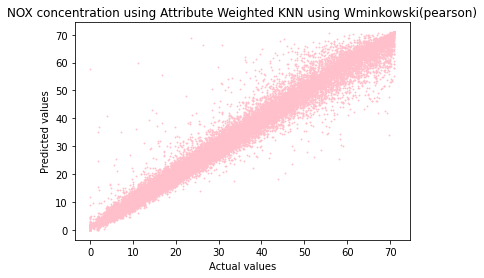

In [16]:
plt.scatter(testing_output, prediction, s = 0.75, c = 'pink')
plt.xlabel('Actual values')
plt.ylabel("Predicted values")
plt.title('NOX concentration using Attribute Weighted KNN using Wminkowski(pearson)')
plt.show()